# Entity Sentiment Analysis on Customer Feedback

## Problem Statement

Understanding customer reviews to identify critical issues in the product design and their demand is a essential part of growth for any company trying to improve customer experience. Amazon has provided many retailers an amazing platform called the "sellers central" to sell their products and also collect customers feedback. It has become crutial for companies to react on the feedback recieved in order to increase the customer base as well as maintain the current customers.

In this project we aim to recognize the sentiment of customers on certain products based on their reviews in Amazon.

## Importing Libraries

In [126]:
# Make sure to install all packages in requirements.txt before running this cell.
# To install all the required packages run the following command from command prompt:
# pip install -r requirements.txt

# Import built-in libraries
import requests 
import json 
from time import sleep
import csv
from dateutil import parser as dateparser
import pandas as pd
from matplotlib import pyplot as plt
# External libraries that are install from the requirements.txt file.
from selectorlib import Extractor
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ne_chunk
from nltk import pos_tag
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.tree import Tree
from nltk.sentiment import vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
## for language detection
import langdetect

In [130]:
# Downloading from NLTK the required elements
nltk.download("stopwords") # List of stop words.
nltk.download('punkt') # This tokenizer divides a text into a list of sentences.
nltk.download('averaged_perceptron_tagger') # Tags parts of speech to words.
nltk.download('maxent_ne_chunker') # Extracts phrases from text
nltk.download('words') # Words corpus - collection of words
nltk.download('wordnet') # Wordnet for Lemmatization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fortune\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fortune\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fortune\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\fortune\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\fortune\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fortune\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\

True

In [175]:
# Create an Extractor by reading from the YAML file
selectors_ext = Extractor.from_yaml_file('selectors.yml')

In [180]:
def scrape(url):
    """Function to scrape customer reviews from Amazon.com

    Args:
        url (str): URL to scrape data from.

    Returns:
        str: The contents of the HTML page in the form of text
    """

    headers = {
        'authority': 'www.amazon.com',
        'pragma': 'no-cache',
        'cache-control': 'no-cache',
        'dnt': '1',
        'upgrade-insecure-requests': '1',
        'user-agent':'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'sec-fetch-site': 'none',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-dest': 'document',
        'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
    }

    # Download the page using requests
    print("Downloading %s"%url)
    request = requests.get(url, headers=headers)
    # Simple check to check if page was blocked (Usually 503)
    if request.status_code > 500:
        if "To discuss automated access to Amazon data please contact" in request.text:
            print("Page %s was blocked by Amazon. Please try using better proxies\n"%url)
        else:
            print("Page %s must have been blocked by Amazon as the status code was %d"%(url,request.status_code))
        return None
    # Pass the HTML of the page and create 
    return selectors_ext.extract(request.text)

In [181]:
def generate_input_data():
    """Write the reviews and its relative content of each url in urls.csv into data.csv file 
    """
    # Creating an empty dataframe to hold the data
    customer_reviews = pd.DataFrame()
    # Reading URLs from urls.txt and writing the contents to data.csv file
    with open("urls.txt",'r') as urllist, open('data.csv','w', newline='', encoding="utf-8") as outfile:
        writer = csv.DictWriter(outfile, fieldnames=["title","content","date","variant","images","verified","author","rating","product","url"],quoting=csv.QUOTE_ALL)
        writer.writeheader()
        # Iterating through each URL
        for url in urllist.readlines():
            # Get response as a text
            data = scrape(url) 
            if data:
                # Iterate through the reviews and store relavent information
                for review in data['reviews']:
                    review["product"] = data["product_title"]
                    review['url'] = url
                    if 'verified' in review:
                        if not review['verified'] or 'Verified Purchase' in review['verified']:
                            review['verified'] = 'Yes'
                        else:
                            review['verified'] = 'Yes'
                    if 'rating' in review and review['rating']:
                        review['rating'] = review['rating'].split(' out of')[0]
                    date_posted = review['date'].split('on ')[-1]
                    if review['images']:
                        review['images'] = "\n".join(review['images'])
                    review['date'] = dateparser.parse(date_posted).strftime('%d %b %Y')
                    customer_reviews = customer_reviews.append(review, ignore_index=True)
                    writer.writerow(review)
    return customer_reviews


In [182]:
# Scraping customer reviews and creating a dataframe and also storing them into a csv file for review.
customer_reviews = generate_input_data()

In [183]:
customer_reviews.head()

,author,content,date,images,product,rating,title,url,variant,verified
0,tyler,"I normally don't do reviews but, if you're lik...",23 May 2020,None,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",4.0,Reliable Spec Information,https://www.amazon.com/Lenovo-IdeaPad-Processo...,None,Yes
1,XHG,The Lenovo Ideapad 3 14 laptop is a very solid...,03 Aug 2020,None,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",5.0,Can't Beat The Price For This Performance!,https://www.amazon.com/Lenovo-IdeaPad-Processo...,None,Yes
2,Salvador Uriel López Díaz,La publicación anuncia 8 GB de memoria ram y s...,11 Jun 2020,None,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",None,None,https://www.amazon.com/Lenovo-IdeaPad-Processo...,None,Yes
3,Maka Lipa,This computer came with different CPU (2 core...,30 Sep 2020,None,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",None,None,https://www.amazon.com/Lenovo-IdeaPad-Processo...,None,Yes
4,Amazon.caUser,"Although the 14"" IdeaPad 3 was a budget comput...",18 Jul 2020,None,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",None,None,https://www.amazon.com/Lenovo-IdeaPad-Processo...,None,Yes


In [184]:
customer_reviews['lang'] = customer_reviews["content"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")
customer_reviews.head()


,author,content,date,images,product,rating,title,url,variant,verified,lang
0,tyler,"I normally don't do reviews but, if you're lik...",23 May 2020,None,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",4.0,Reliable Spec Information,https://www.amazon.com/Lenovo-IdeaPad-Processo...,None,Yes,en
1,XHG,The Lenovo Ideapad 3 14 laptop is a very solid...,03 Aug 2020,None,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",5.0,Can't Beat The Price For This Performance!,https://www.amazon.com/Lenovo-IdeaPad-Processo...,None,Yes,en
2,Salvador Uriel López Díaz,La publicación anuncia 8 GB de memoria ram y s...,11 Jun 2020,None,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",None,None,https://www.amazon.com/Lenovo-IdeaPad-Processo...,None,Yes,es
3,Maka Lipa,This computer came with different CPU (2 core...,30 Sep 2020,None,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",None,None,https://www.amazon.com/Lenovo-IdeaPad-Processo...,None,Yes,en
4,Amazon.caUser,"Although the 14"" IdeaPad 3 was a budget comput...",18 Jul 2020,None,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",None,None,https://www.amazon.com/Lenovo-IdeaPad-Processo...,None,Yes,en


## Visualization

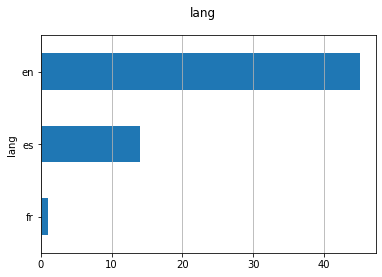

In [185]:
fig, ax = plt.subplots()
fig.suptitle("lang", fontsize=12)
customer_reviews["lang"].reset_index().groupby("lang").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [186]:
# We are filtering out other languages as English is the language we want to focus on.
customer_reviews = customer_reviews[customer_reviews["lang"]=="en"]

In [187]:
def get_continuous_chunks(text):
    """Recognize entities in the review text
 
    Args:
        text (str): Customer review

    Returns:
        list: List of entity strings inside the review
    """
    lemmatizer = WordNetLemmatizer() 
    # Tokenize the words in the review
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []
    # Identifying unique entities in the reviews
    for i in chunked:
            if type(i) == Tree:
                    current_chunk.append(" ".join([lemmatizer.lemmatize(token) for token, pos in i.leaves()]))
            if current_chunk:
                    named_entity = " ".join(current_chunk)
                    if named_entity not in continuous_chunk:
                            continuous_chunk.append(named_entity)
                            current_chunk = []
            else:
                    continue
    # Removing stop words
    stop_words = set(stopwords.words('english'))
    continuous_chunk = [w for w in continuous_chunk if not w in stop_words]
    return continuous_chunk

In [188]:
def processing_data(input_dataframe):
    """Retreive entities from the processed reviews and use vader sentiment analyzer to
    calculate the sentiment of all the entities.
    """
    input_dataframe["entities"] = input_dataframe["content"].apply(get_continuous_chunks)
    input_dataframe["scentences"] = input_dataframe["content"].apply(sent_tokenize)
    entity_sentiment_analysis = []
    for row in input_dataframe.iterrows():
        for entity in row[1]["entities"]:
            entity_sentiment_dict = {}
            entity_sentiment_dict.update(row[1])
            for scentence in row[1]["scentences"]:
                if entity in scentence:
                    entity_sentiment_dict["entity_text"] = scentence
                    entity_sentiment_dict["entity_name"] = entity
                    analyzer = SentimentIntensityAnalyzer()
                    sentiment = analyzer.polarity_scores(scentence)
                    if sentiment["neg"] > 0.1:
                        entity_sentiment_dict["sentiment"] = "Negative"
                        entity_sentiment_dict["sentiment_score"] = sentiment["neg"]
                    elif sentiment["pos"] > 0.1:
                        entity_sentiment_dict["sentiment"] = "Positive"
                        entity_sentiment_dict["sentiment_score"] = sentiment["pos"]
                    else:
                        entity_sentiment_dict["sentiment"] = "Neutral"
                        entity_sentiment_dict["sentiment_score"] = sentiment["neu"]
                    entity_sentiment_analysis.append(entity_sentiment_dict)
    output_dataframe = pd.DataFrame(entity_sentiment_analysis)
    output_dataframe.fillna("None", inplace=True)
    output_dataframe["title"] = output_dataframe["title"].replace(","," ")
    output_dataframe["entity_text"] = output_dataframe["entity_text"].replace(","," ")
    output_dataframe.drop(columns = ["entities","scentences","images","url","content"],inplace=True)
    output_dataframe.drop_duplicates()
    output_dataframe.to_csv("output.csv", index=False)
    return output_dataframe

In [189]:
entity_sentiment_analysis = processing_data(customer_reviews)

In [190]:
entity_sentiment_analysis.fillna("None")
entity_sentiment_analysis.head()

,author,date,product,rating,title,variant,verified,lang,entity_text,entity_name,sentiment,sentiment_score
0,tyler,23 May 2020,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",4.0,Reliable Spec Information,None,Yes,en,"The screen is a 1920x1080 TN panel, no touch s...",NVME,Negative,0.108
1,tyler,23 May 2020,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",4.0,Reliable Spec Information,None,Yes,en,"The screen is a 1920x1080 TN panel, no touch s...",HDD,Negative,0.108
2,tyler,23 May 2020,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",4.0,Reliable Spec Information,None,Yes,en,"The screen is a 1920x1080 TN panel, no touch s...",DDR4,Negative,0.108
3,tyler,23 May 2020,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",4.0,Reliable Spec Information,None,Yes,en,Compared to my wife's Lenovo IdeaPad FLEX-14AP...,Lenovo,Neutral,0.924
4,tyler,23 May 2020,"Lenovo IdeaPad 3 14"" Laptop, 14.0"" FHD 1920 x ...",4.0,Reliable Spec Information,None,Yes,en,Compared to my wife's Lenovo IdeaPad FLEX-14AP...,Lenovo,Neutral,0.924


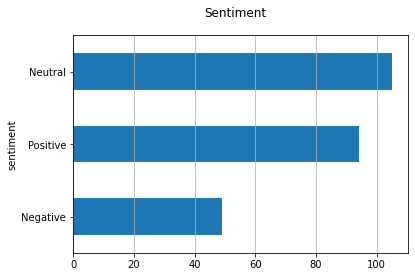

In [191]:
fig, ax = plt.subplots()
fig.suptitle("Sentiment", fontsize=12)
entity_sentiment_analysis["sentiment"].reset_index().groupby("sentiment").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

Dashboard shows the sentiment breakdown for each enitity identified in the program in a descending order to be able to find the products with highest reviews and identify the sentiment with ease.